This notebook examines how genre list length correlates with gender. It creates visualizations of how gender varies with genre list length and uses a chi-square test to show that the variation is extremely unlikely if there were not a correlation (bias) between genre list length and bias.

For each bin (either an integer or a range of integers), calculate
$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$
where the expected number of male artists in a bin is ${\% \text{male in total sample} \cdot \text{total in bin}}$. 

Other approaches:

The list length counts by gender find that in the 11+ range the expected of male to female is 1. However, there are no female artists with > 11 labels. The statistics don't capture the fact that male artists have features that are not available to female artists. By switching to 12+ the inability to carry out the calculation (divide by zero) is informative. 

The data for lists of length > 6 needs to be dealt with carefully. It is exactly at that point that the statistical significant comes into doubt. First, using 10-fold CV to estimate the ratios there is often a zero value which makes the ratio undefined. Second, when filtering the data to only include, e.g. lengths > 5, then the mean of the error and std of the error indicate that there is not a clear effect.

In [1]:
import importlib.util
spec1 = importlib.util.spec_from_file_location("genre_data_loader", "/Users/Daniel/Code/Genre/src/genre_scripts/genre_data_loader.py")

genre_data_loader = importlib.util.module_from_spec(spec1)
spec1.loader.exec_module(genre_data_loader)
#LoadGenreData = genre_data_loader.LoadGenreData

# import genre_scripts.genre_data_loader as genre_data_loader

import numpy as np
import pandas as pd
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
seed = 23
%matplotlib inline
import re
from functools import partial
import plotly.graph_objects as go

Import the cleaned data:

In [2]:
%store -r now
now

'2020-07-07-09-58'

In [3]:
# get currrent date for latest version of data set
%store -r now

X_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now)
y_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now)
X_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_test_{}.csv'.format(now)
y_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_test_{}.csv'.format(now)

In [4]:
# call data loader script
genre_data = genre_data_loader.LoadGenreData(now, X_path_train = X_path_train, y_path_train = y_path_train, 
                                             X_path_test = X_path_test, y_path_test = y_path_test)

In [5]:
# load data with genre sets
data = genre_data.as_sets()
# create list of all genres
list_of_genres = genre_data.get_list_of_genres()

### Import the labels from the whole data set:

In [6]:
genrelist = genre_data.get_list_of_genres()

Get numbers of male and female:

In [7]:
gender_counts = data.gender.value_counts()
mal = gender_counts['male']
fem = gender_counts['female']

Get percentages of male and female:

In [8]:
percent_fem = genre_data.get_percent_female()
percent_mal = genre_data.get_percent_male()

In [9]:
percent_fem, percent_mal

(0.3138332255979315, 0.6861667744020685)

In [10]:
data.shape

(15470, 3)

In [11]:
data.head()

,genrelist_length,gender,genre_set
artist,,,
Pablo_Holman,3,male,"{emo_pop, pop, rock}"
Bobby_Edwards,1,male,{country}
La_Palabra,4,male,"{son_montuno, afro_cuban_jazz, salsa_romántica..."
Sherrick,2,male,"{soul, r_and_b}"
Allen_Collins,1,male,{southern_rock}


In [12]:
data.shape, data.isnull().sum()

((15470, 3),
 genrelist_length    0
 gender              0
 genre_set           0
 dtype: int64)

In [13]:
tot = data.shape[0]
print('{} total artists'.format(tot))
print('There are {} unique genre labels.'.format(len(genrelist)))
print('{} female artists, or {:0.0f}%'.format(fem, 100*fem/(fem+mal)))
print('{} male artists, or {:0.0f}%'.format(mal, 100*mal/(fem+mal)))

15470 total artists
There are 1491 unique genre labels.
4855 female artists, or 31%
10615 male artists, or 69%


### This function creates a DF with the frequencies of the lengths of lists by gender for a df of the type of "data" above. It is used in the bin_cv_est function below.

In [14]:
def create_length_counts_by_gender(df):
    """
    Input: df = genre data for artists:
        columns: 'genrelist_length','gender'
        index: 'artist'
    
    Output: dataframe with counts by gender and total for each 
        length of genre list in the dataset
    
    Use: called to calculate chi-squared test for bias
    """
    
    df = df.copy(deep = True)
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df.index.name = 'genre list length'
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [f'{name[1]} '+f'{name[0]}'.replace("_"," ") for name in df.columns]
    df.fillna(value = 0, inplace = True)
    #create total count
    df['total'] = df[df.columns[0]]+df[df.columns[1]]
    df = df.astype('int32')
    
    return df

In [15]:
### This function creates a DF with the frequencies of the lengths of lists by gender for a df of the type of "data" above. It is used in the bin_cv_est function below.

def create_length_counts_by_gender(df):
    """
    Input: df = genre data for artists:
        columns: 'genrelist_length','gender'
        index: 'artist'
    
    Output: dataframe with counts by gender and total for each 
        length of genre list in the dataset
    
    Use: called by bin_bias to calculate gender bias in two bins,
    small (<6) and large (>5) genre list lengths
    """
    
    df = df.copy(deep = True)
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df.index.name = 'genre list length'
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [f'{name[1]} '+f'{name[0]}'.replace("_"," ") for name in df.columns]
    df.fillna(value = 0, inplace = True)
    #create total count
    df['total'] = df[df.columns[0]]+df[df.columns[1]]
    df = df.astype('int32')
    
    return df

In [16]:
lcbg = create_length_counts_by_gender(data)

In [17]:
lcbg

,female artist count,male artist count,total
genre list length,,,
1,1306,3149,4455
2,1299,2521,3820
3,1072,2043,3115
4,629,1367,1996
5,305,755,1060
6,155,410,565
7,49,189,238
8,20,99,119
9,10,39,49


In [18]:
# bin 11+
lcbg.loc['11+'] = lcbg.loc[11:].sum()
inds = [*range(1,11),'11+']
lcbg = lcbg.loc[inds]
# expected values
lcbg['female artist expected'] = np.ceil(lcbg['total']*percent_fem).astype(int)
lcbg['male artist expected'] = np.floor(lcbg['total']*percent_mal).astype(int)

In [19]:
lcbg

,female artist count,male artist count,total,female artist expected,male artist expected
genre list length,,,,,
1,1306,3149,4455,1399,3056
2,1299,2521,3820,1199,2621
3,1072,2043,3115,978,2137
4,629,1367,1996,627,1369
5,305,755,1060,333,727
6,155,410,565,178,387
7,49,189,238,75,163
8,20,99,119,38,81
9,10,39,49,16,33


Note: the expected number for each category is >= 5, so the chi-squared test is traditionally considered adequate

In [20]:
f_exp = lcbg.loc[:,['female artist expected','male artist expected']].to_numpy()
f_obs = lcbg.loc[:,['female artist count','male artist count']].to_numpy()

In [21]:
chisq, p = chisquare(f_obs, f_exp)

In [22]:
p_fem, p_mal = p[0], p[1]

In [23]:
p_fem, p_mal

(9.540063142395242e-08, 0.0066732169748814464)

## Bar Graph of Gender Bias

In [25]:
df_bias = pd.DataFrame(index = lcbg.index, columns = ['female', 'male'])
df_bias['female'] = lcbg['female artist count']/lcbg['female artist expected']
df_bias['male'] = lcbg['male artist count']/lcbg['male artist expected']

In [26]:
df_bias

,female,male
genre list length,,
1,0.933524,1.030432
2,1.083403,0.961847
3,1.096115,0.956013
4,1.003190,0.998539
5,0.915916,1.038514
6,0.870787,1.059432
7,0.653333,1.159509
8,0.526316,1.222222
9,0.625000,1.181818


In [28]:
ind_fem = np.arange(1, 3*df_bias.shape[0], 3)
ind_mal = np.arange(2, 3*df_bias.shape[0], 3)
ind_fem, ind_mal

(array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31]),
 array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32]))

In [48]:
np.array([5])

array([5])

In [58]:
np.arange(1.5,12.5,1)

array([ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5])

In [61]:
def plot_gender_bias(df_bias):
    
    x_fem = np.arange(1, 3*df_bias.shape[0], 3)
    x_mal = np.arange(2, 3*df_bias.shape[0], 3)
    xticklabels = df_bias.index.to_list()
    xlabel_pos = np.arange(1.5,12.5,1)
    
    fig, axs = plt.subplots(1, figsize = (14,10))
    fig.tight_layout(pad = 6.0)
    fig.suptitle('The ratio of actual to expected numbers of female and male artists.', fontsize = 20)
    axs.bar(x_fem,df_bias.female, color = 'orange', label = 'female')
    axs.bar(x_mal,df_bias.male, color = 'purple', label = 'male')

    # y range
    axs.set_ylim(0,1.7)

    # styles
    axs.set_title('Gender Bias In Genre List Length'.title(), fontsize = 14)

    axs.set_xticks(xlabel_pos)
    axs.set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
    axs.set_xlabel('Genre List Length', fontsize = 12)
    axs.legend()
    
    return fig

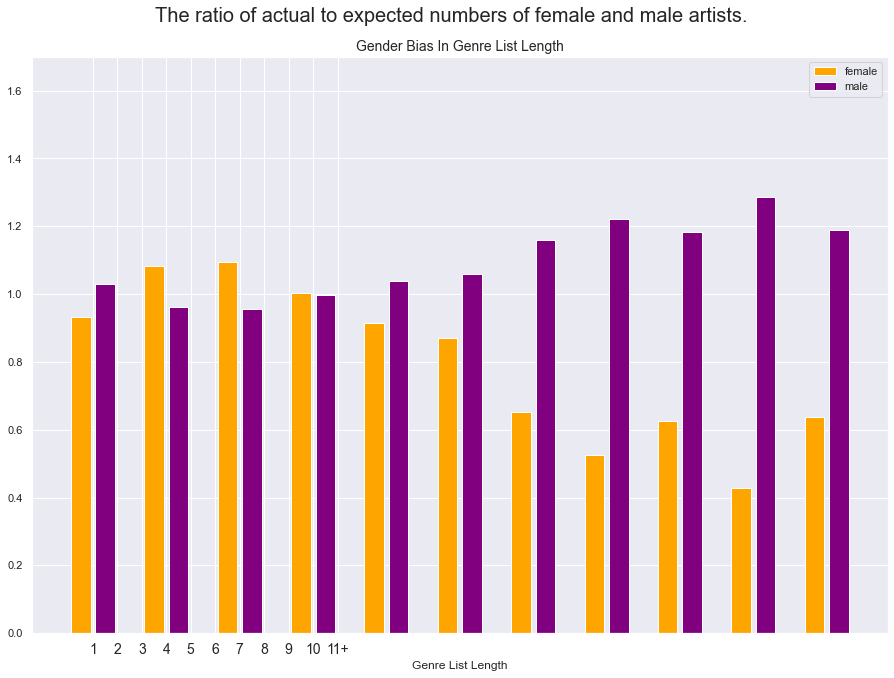

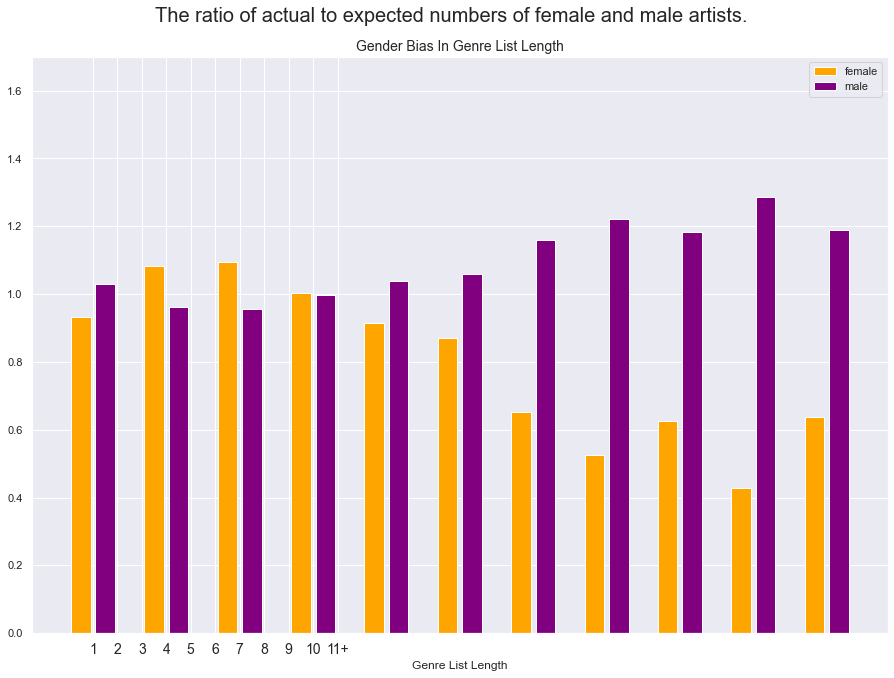

In [62]:
plot_gender_bias(df_bias)